# <center> Проект: Анализ вакансий из HeadHunter
   

In [1]:
import pandas as pd
import psycopg2

# Подавляем warning о испольтзовании SQLAlchemy connectable
import warnings
warnings.simplefilter(action = 'ignore', category=UserWarning)

In [2]:
# в корневой папке с проектом создаём файл .env туда переносим 5 переменных
# во кладке source control добавляем .env файл в gitignore

DBNAME = 'project_sql'
USER = 'skillfactory'
PASSWORD = 'cCkxxLVrDE8EbvjueeMedPKt'
HOST = '84.201.134.129'
PORT = 5432

In [ ]:
# теперь мы можем используя dotenv подгрузить значения этих переменных сразу в код

import os
from dotenv import load_dotenv

load_dotenv()
DBNAME = os.getenv("DBNAME")
USER = os.getenv("USER")
PASSWORD = os.getenv("PASSWORD")
HOST = os.getenv("HOST")
PORT = os.getenv("PORT")

In [3]:
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [4]:
# текст запроса
query_3_1 = f'''
select 
        count(*) as vacancies_cnt
    from public.vacancies
'''

In [5]:
# результат запроса
df = pd.read_sql_query(query_3_1, connection)
print( f'Количество вакансий: {df["vacancies_cnt"].iloc[0]}' )


Количество вакансий: 49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [6]:
# текст запроса
query_3_2 = f'''
select 
        count(*) as employers_cnt
    from public.employers
'''

In [7]:
# результат запроса
df = pd.read_sql_query(query_3_2, connection)
print( f'Количество работодателей: {df["employers_cnt"].iloc[0]}' )


Количество работодателей: 23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [8]:
# текст запроса
query_3_3 = f'''
select 
        count(*) as areas_cnt
    from public.areas
'''

In [9]:
# результат запроса
df = pd.read_sql_query(query_3_3, connection)
print( f'Количество регионов: {df["areas_cnt"].iloc[0]}' )

Количество регионов: 1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [10]:
# текст запроса
query_3_4 = f'''
select 
        count(*) as industries_cnt
    from public.industries
'''

In [11]:
# результат запроса
df = pd.read_sql_query(query_3_4, connection)
print( f'Количество сфер деятельности: {df["industries_cnt"].iloc[0]}' )

Количество сфер деятельности: 294


***

# выводы по предварительному анализу данных

- 49197 вакансия;
- 23501 работодатель;
- 1362 регион;
- 294 сфера деятельности.


1. В среднем 1 работодатель дал 2 вакасии
2. В среднем 167 вакансий на сферу деятельности
3. В среднем 36 вакансий на регион

Видим, что цифры не больщие, рынок стабилизорован и насыщен

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [13]:
# текст запроса
query_4_1 = f'''
select a.name, count( v.area_id ) as vacancies_cnt
    from public.areas a
    left join public.vacancies v on a.id = v.area_id
    group by a.name, a.id
    order by vacancies_cnt desc
'''

In [14]:
# результат запроса
df = pd.read_sql_query(query_4_1, connection)
display( df )

,name,vacancies_cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
1357,Балакирево,0
1358,Мексика,0
1359,Пугачев,0
1360,Долгоруково,0


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [15]:
# текст запроса
query_4_2 = f'''
select count(*) as vacancies_cnt
    from public.vacancies v
    where
        v.salary_from is not null or v.salary_to is not null
'''

In [16]:
# результат запроса
df = pd.read_sql_query(query_4_2, connection)
print( f'Количество вакансий с непустыми полями с зарплатой: {df["vacancies_cnt"].iloc[0]}' )


Количество вакансий с непустыми полями с зарплатой: 24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [17]:
# текст запроса
query_4_3 = f'''
select 
        round( avg( v.salary_from ), 0 )::int as salary_from_avg, 
        round( avg( v.salary_to ), 0 )::int as salary_to_avg
    from public.vacancies v
'''

In [18]:
# результат запроса
df = pd.read_sql_query(query_4_3, connection)
print( f'Средняя нижняя граница заработной платы: {df["salary_from_avg"].iloc[0]} руб\nСредняя верхняя граница заработной платы: {df["salary_to_avg"].iloc[0]} руб' )

Средняя нижняя граница заработной платы: 71065 руб
Средняя верхняя граница заработной платы: 110537 руб


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [19]:
# текст запроса
# Для наглядности отсортируем еще по остальным полям. Это не повлияет на сортироку по убыванию количества
query_4_4 = f'''
select v.schedule, v.employment, count(*) as vacancies_cnt
    from public.vacancies v
    group by v.schedule, v.employment
    order by vacancies_cnt desc, v.schedule, v.employment
'''

In [20]:
# результат запроса
df = pd.read_sql_query(query_4_4, connection)
display( df )

,schedule,employment,vacancies_cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [21]:
# текст запроса
query_4_5 = f'''
select v.experience, count(*) as vacancies_cnt
    from public.vacancies v
    group by v.experience
    order by vacancies_cnt asc, v.experience
'''

In [22]:
# результат запроса
df = pd.read_sql_query(query_4_5, connection)
display( df )

,experience,vacancies_cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

# выводы по детальному анализу вакансий
1. Есть регионы без вакансий. В основном - это мелкие регионы (хотя есть и исключения - требуется дополнительный анализ). Вакансии - в крупных городах
2. Более половины данных по вакансиям имеют не заполненные границы заработных плат. Это явление тоже требует дополнительный анализ.
3. Средние значения нижней и верхней граний заработных плат отличается не в разы, а не слишком сильно. Предполагаю, что разница из-за региона (миллионник и поменьше), требуется дополнительный анализ.
4. Наибольшей популярностью пользуются вакансии на полный рабочий день и полную занятость. Также в топе полный рабочий день. 
5. Наибольший спрос на специалистов с опытом работы от 1 до 3х лет, наименьший - на обладателей большого опыта. Имеющие максимальный опыт работы выбывают по естественным причинам (пенсия и тд). Большой спрос на специалистов 1-3 года возможно связан с текучкой кадров. 

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [23]:
# текст запроса
query_5_1 = f'''
with v_top5 as
(
select e.name, count( v.id ) as vacancies_cnt
    from public.employers e
    left join public.vacancies v on v.employer_id = e.id
    group by e.id, e.name
    order by vacancies_cnt desc
    limit 5
)

(select * from v_top5 t limit 1)
union all (select * from v_top5 t limit 1 offset 4)
'''

In [24]:
# результат запроса
df = pd.read_sql_query(query_5_1, connection)
display( df )

,name,vacancies_cnt
0,Яндекс,1933
1,Газпром нефть,331


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [25]:
# текст запроса
query_5_2 = f'''
select 
        a.name, 
        count( distinct v.id ) as vacancies_cnt, 
        count( distinct e.id ) as employers_cnt
    from public.areas a
    join public.vacancies v on v.area_id = a.id
    join public.employers e on v.employer_id = e.id
    group by a.id, a.name

union all
(
select 
        a.name, 
        0 as vacancies_cnt, 
        count( distinct e.id ) as employers_cnt
    from public.areas a
    join public.employers e on e.area = a.id
    where not exists
    (
        select 1
            from public.vacancies v 
            where v.area_id = a.id
    )
    group by a.id, a.name
    order by employers_cnt desc
    limit 1
)
'''


In [26]:
# результат запроса
df = pd.read_sql_query(query_5_2, connection)
display( df )

,name,vacancies_cnt,employers_cnt
0,Москва,5333,2320
1,Санкт-Петербург,2851,1451
2,Екатеринбург,1698,742
3,Новосибирск,2006,802
4,Австрия,4,1
...,...,...,...
765,Актогай,1,1
766,Большие Вязёмы,1,1
767,Софьино (Раменский район),2,2
768,Сириус,1,1


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [27]:
# текст запроса
query_5_3 = f'''
select e.name, count( distinct a.id ) as areas_cnt
    from public.employers e
    join public.vacancies v on v.employer_id = e.id
    join public.areas a on v.area_id = a.id
    group by e.id, e.name
    order by areas_cnt desc
'''

In [28]:
# результат запроса
df = pd.read_sql_query(query_5_3, connection)
display( df )

,name,areas_cnt
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
14901,НПП Авиатрон,1
14902,Центр дистанционных торгов,1
14903,Городские Телекоммуникационные Системы,1
14904,"Введенский, Отель",1


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [29]:
# текст запроса
query_5_4 = f'''
select count(*) as employers_cnt
    from public.employers e
    
    left join public.employers_industries ei on ei.employer_id = e.id
    left join public.industries i on ei.industry_id = i.id
    where
        i.id is null
'''

In [30]:
# результат запроса
df = pd.read_sql_query(query_5_4, connection)
print( f'У {df["employers_cnt"].iloc[0]} работодателей не указана сфера деятельности' )


У 8419 работодателей не указана сфера деятельности


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [31]:
# текст запроса
query_5_5 = f'''
select e.name
    from public.employers e
    join public.employers_industries ei on ei.employer_id = e.id
    join public.industries i on ei.industry_id = i.id
    group by e.name, e.id
    having count(*) = 4
    order by lower( e.name )
    limit 1
    offset 2
'''

In [32]:
# результат запроса
df = pd.read_sql_query(query_5_5, connection)
display( df )

,name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [33]:
# текст запроса
query_5_6 = f'''
select count( distinct e.id ) as employers_cnt
    from public.employers e
    join public.employers_industries ei on ei.employer_id = e.id
    join public.industries i on ei.industry_id = i.id and i.name ilike 'Разработка программного обеспечения'
'''

In [34]:
# результат запроса
df = pd.read_sql_query(query_5_6, connection)
display( df )

,employers_cnt
0,3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [35]:
# код для получения списка городов-милионников
import requests # Импортируем библиотеку requests
from bs4 import BeautifulSoup # Импортируем библиотеку BeautifulSoup

########################################################################
#
# Возвращает строку списка городов, заключенных в одинарные ковычки и соединенных запятыми для подстановки в sql запрос
# Пример: "'Москва','Санкт-Петербург','Новосибирск'"
#
# Данные берутся из таблицы сайта https://ru.wikipedia.org/wiki/Города-миллионеры_России
#
########################################################################
def get_towns_million():
    url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России' # URL городов-миллионников
    response = requests.get(url) # Делаем GET-запрос к ресурсу и результат ответа сохраняем в переменной response

    soup = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер

    towns_million = [] # Список искомых городов-миллионников
    lines = soup.find_all( 'td' ) # Сужаем поиск до таблицы
    for items in lines[ 1: ]: 
        item = items.find( 'a' ) # Затем до ячейки с тэгом <a>
        if item and len( towns_million ) < 16: # После 16 элемента идет не нужная нам информация
            towns_million.append( "'" + item.text + "'" ) # Сразу заключаем в одинарные ковычки город 

    return ','.join( towns_million ) # Склеиваем список городов в строку, годную для sql запроса

print( get_towns_million() ) # Тестируем функцию


'Москва','Санкт-Петербург','Новосибирск','Екатеринбург','Казань','Красноярск','Нижний Новгород','Челябинск','Уфа','Краснодар','Самара','Ростов-на-Дону','Омск','Воронеж','Пермь','Волгоград'


In [36]:
# текст запроса
towns_million = get_towns_million()

query_5_7 = f'''
with v_vacancies_million as
(
    select a.name as area_name, count(*) as cnt
        from public.employers e
        join public.vacancies v on v.employer_id = e.id
        join public.areas a on a.id = v.area_id and a.name in (''' + towns_million + ''')
        where
            e.name ilike 'Яндекс'
        group by e.id, a.id, a.name
        
)

(select vm.area_name, vm.cnt from v_vacancies_million vm order by cnt)
union all
(select 'Total' as area_name, sum( vm.cnt ) as cnt from v_vacancies_million vm order by cnt)
'''

In [37]:
# результат запроса
df = pd.read_sql_query(query_5_7, connection)
display( df )

,area_name,cnt
0,Омск,21.0
1,Челябинск,22.0
2,Красноярск,23.0
3,Волгоград,24.0
4,Ростов-на-Дону,25.0
5,Казань,25.0
6,Пермь,25.0
7,Самара,26.0
8,Уфа,26.0
9,Краснодар,30.0


***

# выводы по анализу работодателей
1. Максимальное количество вакансий среди крупных компаний (коммуникационные/интернет услуги и банки и другие компании с охватом на всю страну)
2. Ожидаемо, что количество вакансий и работодатедей больше в крупных городах. 
3. Среди городов-миллионников количество вакансий Яндекса выше 20 

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [38]:
# текст запроса
query_6_1 = f'''
select count(*) as vacancies_cnt
    from public.vacancies v
    where
        v.name ilike '%data%'
        or v.name ilike '%данн%'
'''

In [39]:
# результат запроса
df = pd.read_sql_query(query_6_1, connection)
display( df )

,vacancies_cnt
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [40]:
# текст запроса
query_6_2 = f'''
select count(v.name) as vacancies_cnt
    from public.vacancies v
    where
        (
            v.name ilike '%data scientist%'
            or v.name ilike '%data science%'
            or v.name ilike '%исследователь данных%'
            or ((v.name ilike '%ML%') and (name not ilike '%HTML%'))
            or v.name ilike '%machine learning%'
            or v.name ilike '%машинн%обучен%'
        )
        and
        (
            v.name ilike '%junior%'
            or v.experience ilike '%Нет опыта%'
            or v.employment ilike '%Стажировка%'
        )
'''

In [41]:
# результат запроса
df = pd.read_sql_query(query_6_2, connection)
display( df )

,vacancies_cnt
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [43]:
# текст запроса
query_6_3 = f'''
select count(v.name) as vacancies_cnt
    from public.vacancies v
    where
        (
            1=0
            or name ilike '%data scientist%'
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or ((name ilike '%ML%') and (name not ilike '%HTML%'))
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%'
        )
        and
        (
            v.key_skills ilike '%SQL%'
            or v.key_skills ilike '%postgres%'
        )
'''

In [44]:
# результат запроса
df = pd.read_sql_query(query_6_3, connection)
display( df )

,vacancies_cnt
0,229


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [45]:
# текст запроса
query_6_4 = f'''
select count(v.name) as vacancies_cnt
    from public.vacancies v
    where
        (
            name ilike '%data scientist%'
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or ((name ilike '%ML%') and (name not ilike '%HTML%'))
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%'
        )
        and
        (
            v.key_skills ilike '%python%'
        )
'''

In [46]:
# результат запроса
df = pd.read_sql_query(query_6_4, connection)
display( df )

,vacancies_cnt
0,357


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [47]:
# текст запроса
query_6_5 = f'''
select round( avg( length( v.key_skills ) - length( replace( key_skills, chr( 9 ), '' ) ) + 1 ), 2 ) as vacancies_cnt
    from public.vacancies v
    where
        (
            name ilike '%data scientist%'
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%'
            or name like '%ML%'
        )
        and name not ilike '%HTML%'
'''

In [48]:
# результат запроса
df = pd.read_sql_query(query_6_5, connection)
display( df )

,vacancies_cnt
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [49]:
# текст запроса
query_6_6 = f'''
select 
        round
        (
            avg
            ( 
                case
                    when v.salary_from is not null and v.salary_to is not null then (v.salary_from + v.salary_to) / 2
                    when v.salary_from is not null then v.salary_from
                    else v.salary_to
                end
            )
            , 0
        )::int as salary_avg
    from public.vacancies v
    where
        (
            1=0
            or name ilike '%data scientist%'
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%'
        )
        and name not ilike '%HTML%'
        and (v.salary_from is not null or v.salary_to is not null)
        and v.experience = 'От 3 до 6 лет'
'''

In [50]:
# результат запроса
df = pd.read_sql_query(query_6_6, connection)
display( df )

,salary_avg
0,243115


# выводы по предметному анализу
1. Уровень зарплаты опытного специалиста по data scince высокий
2. Но вакансий для начинающих не много. Начинающим трудно пробиться в этой области и нужно иметь сразу высокую стартовую квалификацию (6 skills как минимум)
3. Python дает немного больше вакансий, чем postgres, но нужно иметь знания и опыт в обоих областях обязательно


***

# Общий вывод по проекту

Проведем дополнительный исследования

In [51]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования

In [52]:
import plotly.io as pio
import plotly.express as px
import numpy as np
# Дефорлный формат изображений
pio.renderers.default = "png"

Посмотрим топ 20 вакансий

In [53]:
# текст запроса
query_6_6 = f'''
select 
        replace( v.name, '1C', '1С' ) as name, -- Склеиваем разные варианты написания
        count(*) as cnt
    from public.vacancies v 
    where 
        (v.salary_from is not null or v.salary_to is not null)
    group by v.name
    order by cnt desc
    limit 20
'''

In [54]:
df = pd.read_sql_query(query_6_6, connection)

tmp_df = df.copy()

# Имеем отображение признака и категории - выбираем столбчатые диаграммы
fig = px.bar(
    data_frame = tmp_df,
    y = "name", # Ось y - Название вакансии
    x = "cnt", # Ось x - количество вакансий
    title = 'Топ 20 вакансий', # Заголовак графика
    color = "cnt", # Цветовой индикатор
    labels = { "cnt": "Кол-во" }, # Переименуем шкалу
    text_auto = True # Включим подписи
)
fig.update_layout(
    xaxis_title = 'Количество вакансий', # Подпись оси x
    yaxis_title = 'Название вакансии', # Подпись оси y
    title_x = 0.5, # Центрируем по оси x заголовок
    showlegend = False # Легенда не нужна
)

# Выводим на экран
fig.show( width = 1000, height = 800 ) # Отображаем, Ширина и высота изображения


ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


В больших городах вакансий больше. Наибольший запрос вакансий предоставляют крупные работодатели федерального уровня. Чем больше опыт, тем ниже текучка кадров, максимальное количество вакансий для соискателей с небольшим опытом. Больше всего вакансий на полную занятость.
Средняя заработная плата для специалистов data scientis с опытом от 3 до 6 лет выше, чем в среднем по IT.

Проанализируем распределение заработных плат вакансий в больших городах. В качестве суммы берем полусумму границ или только 1 границу (если 2я не задана). Аномальные данные и отсутствующие по суммам данные не берем к анализу.

In [55]:
# Попучим строку городов миллионников, разделенных запятыми и в одинарных ковычках (для sql запроса)
towns_million = get_towns_million()

# текст запроса
query_7_2 = f'''
select *
    from
    (
        select 
                a.name, 
                round
                (
                    case
                        when v.salary_from is not null and v.salary_to is not null then (v.salary_from + v.salary_to) / 2
                        when v.salary_from is not null then v.salary_from
                        else v.salary_to
                    end
                    , 0
                )::int as sm
                
            from public.areas a
            join public.vacancies v on a.id = v.area_id
            where 
                a.name in (''' + towns_million + ''') and
                (v.salary_from is not null or v.salary_to is not null)
    ) t   
    where t.sm between 30000 and 400000 --Убираем аномальные данные
'''

In [56]:
# результат запроса
df = pd.read_sql_query(query_7_2, connection)
tmp_df = df.copy()

# Массив распределений числовых признаков - используем коробчатую диаграмму
fig = px.box(
    tmp_df, # Датафрейм
    x = "sm", # Ось x - ЗП
    y = "name",  # Ось y - Город
    title = 'Распределение ЗП по городам-миллионникам'  # Заголовак графика
)
fig.update_layout( { "xaxis_title": "ЗП, руб", "yaxis_title": "Город - миллионник"  } ) # Подписи осей

# Выводим на экран
fig.show( width = 1000, height = 800 ) # Отображаем, Ширина и высота изображения


ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


Среди городов-миллионников по медианной ЗП с отрывом лидирует Москва, замыкает группу Волгоград

А теперь выберем топ 20 городов не миллионников с наибольшей средней ЗП. В качестве суммы берем полусумму границ или только 1 границу (если 2я не задана). Аномальные данные и отсутствующие по суммам данные не берем к анализу.

In [57]:

# Попучим строку городов миллионников, разделенных запятыми и в одинарных ковычках (для sql запроса)
towns_million = get_towns_million()

# текст запроса
query_7_2  = f'''
select t.name, t.sm
    from
    (
        select *, dense_rank() over( order by t.sm_avg desc ) as nn --Ранжируем 
            from
            (
                select 
                        t.*
                        
                        -- вычисляем анилитическими функциями среднее по городу и количество (для отсеивания выбросов)
                        , avg( t.sm ) over( partition by t.name ) as sm_avg 
                        , count(*) over( partition by t.name ) as vacancies_cnt
                    from
                    (
                        select 
                                a.name, 
                                round
                                (
                                    case
                                        when v.salary_from is not null and v.salary_to is not null then (v.salary_from + v.salary_to) / 2
                                        when v.salary_from is not null then v.salary_from
                                        else v.salary_to
                                    end
                                    , 0
                                )::int as sm
                                
                            from public.areas a
                            join public.vacancies v on a.id = v.area_id
                            where 
                                a.name not in (''' + towns_million + ''') and
                                --v.schedule = ('Полный день', 'Удаленная работа') and
                                (v.salary_from is not null or v.salary_to is not null)
                    ) t   
                    where t.sm between 30000 and 400000 --Убираем аномальные данные
            ) t
            where t.vacancies_cnt > 100 -- Считаем ненадежные данные по городу с менее, чкм 100 вакансиями (отбрасываем их)
    ) t
    where t.nn <= 20 -- Из оставшихся городов выбираем топ 20
'''

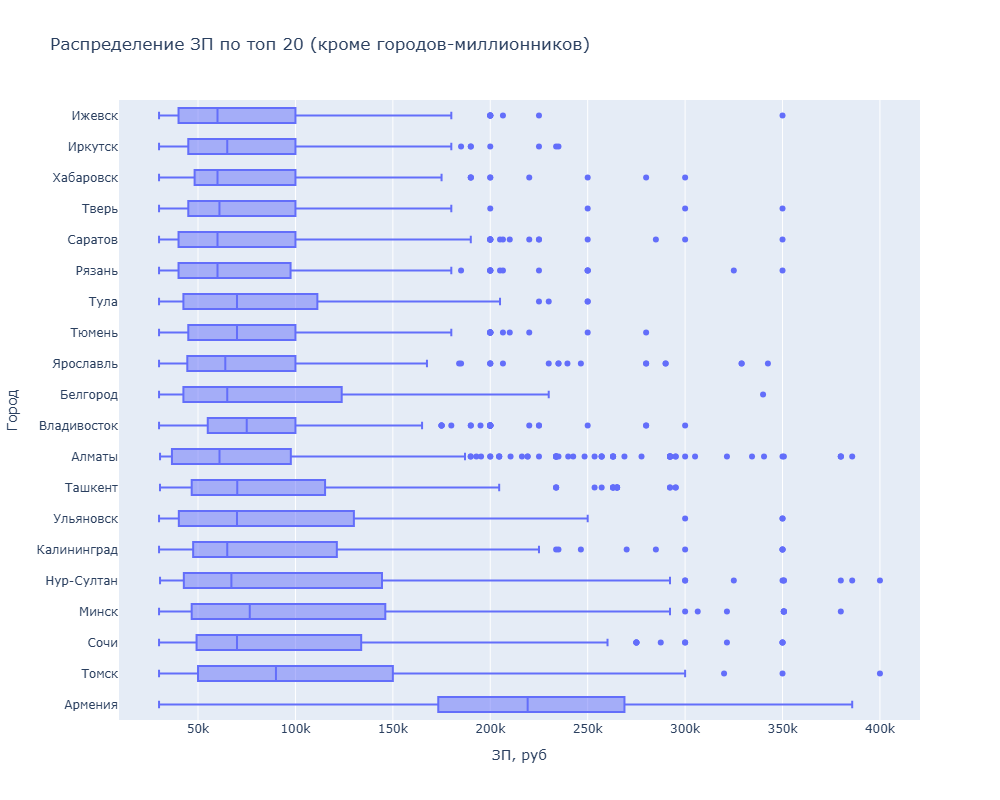

In [ ]:
# результат запроса
df = pd.read_sql_query(query_7_2, connection)
tmp_df = df.copy()

# Массив распределений числовых признаков - используем коробчатую диаграмму
fig = px.box(
    tmp_df, # Датафрейм
    x = "sm", # Ось x - ЗП
    y = "name",  # Ось y - Город
    title = 'Распределение ЗП по топ 20 (кроме городов-миллионников)'  # Заголовак графика
)
fig.update_layout( { "xaxis_title": "ЗП, руб", "yaxis_title": "Город"  } ) # Подписи осей

# Выводим на экран
fig.show( width = 1000, height = 800 ) # Отображаем, Ширина и высота изображения


В остальных регионах медианная ЗП ниже (исключение - Армения)

# ИТОГОВЫЙ ВЫВОД

1) С ростом городов растет количество вакансий в них и медианная заработная плата.
2) Наибольший запрос вакансий предоставляют крупные работодатели федерального уровня, имеющий широкий охват регионов. 
3) Чем больше опыт, тем ниже текучка кадров, максимальное количество вакансий для соискателей с небольшим опытом.
4) Больше всего вакансий на полную занятость.
5) Больше всего требуется системных администраторов и специалистов 1С
6) Средняя заработная плата для специалистов data scientis с опытом от 3 до 6 лет выше, чем в среднем по IT. И перспективное направление. Но требуется серьезная подготовка по этому интересному направлению (входной порог высокий).

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

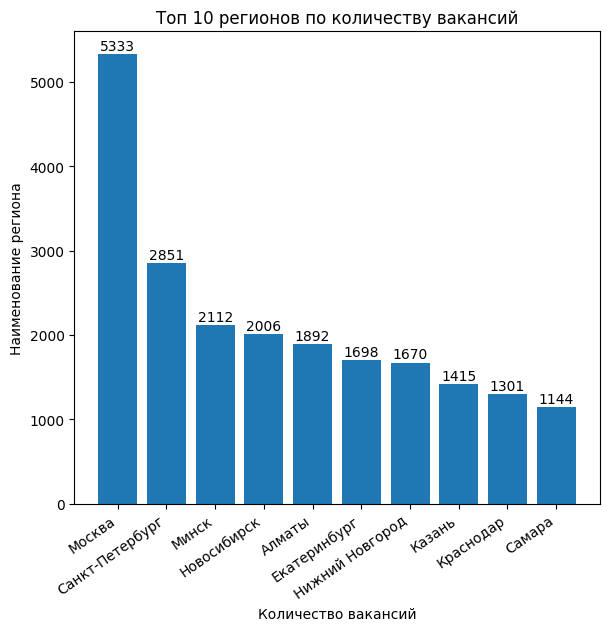

In [61]:
top_10_cities = '''
SELECT
    COUNT(v.id) AS cnt,
    a.name AS area
FROM vacancies v
JOIN areas a ON v.area_id=a.id
GROUP BY a.name
ORDER BY cnt DESC
LIMIT 10
'''

df = pd.read_sql_query(top_10_cities, connection)

import matplotlib.pyplot as plt
# создадим фигуру и отрисуем график 
fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(x=df.area.values, height=df.cnt.values)

# Добавим подписи данных
for at_x, at_y in enumerate(df.cnt):
    ax.text(at_x, at_y + 50, round(at_y, 1), horizontalalignment='center')

# Повернём подписи столбцов на оси х
plt.xticks(rotation=35, horizontalalignment='right')
plt.tight_layout()

# добавим подписи осей и графика
ax.set(xlabel='Количество вакансий', 
       ylabel='Наименование региона', 
       title='Топ 10 регионов по количеству вакансий',
       );


# выведем на экран результат
fig.show()

C:\Users\Miguel\AppData\Local\Temp\ipykernel_16144\2793566692.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




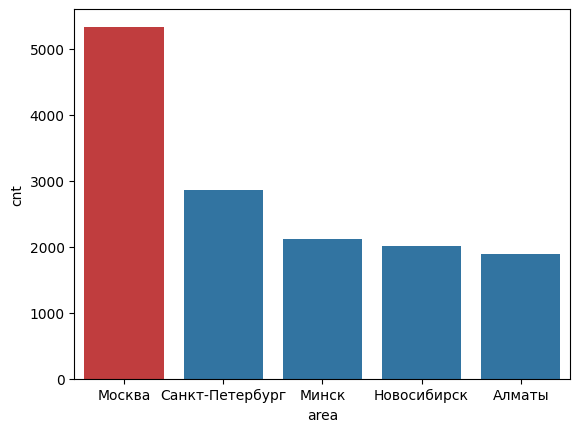

In [62]:
query_4_1 = f'''
SELECT a.name area, COUNT(v.area_id) cnt
FROM vacancies v JOIN areas a ON v.area_id = a.id
GROUP BY a.id, a.name
ORDER BY 2 DESC
LIMIT 5
'''
df = pd.read_sql_query(query_4_1, connection)

filtred_color = [('tab:red' if x > 3000 else 'tab:blue') for x in df.cnt]
sns.barplot(df, x='area', y='cnt', palette=filtred_color);

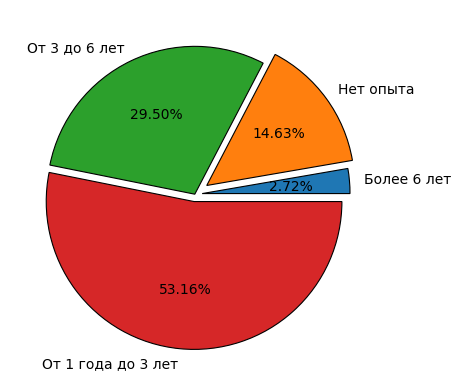

In [63]:
query_4_5 = f'''
SELECT experience, COUNT(id)
FROM vacancies
GROUP BY 1
ORDER BY 2
'''
df = pd.read_sql_query(query_4_5, connection)

plt.pie(
    df['count'],
    labels = df['experience'].values,
    autopct = '%.2f%%',
    explode = (0.05, 0.1, 0, 0.05),
    wedgeprops = {'lw':0.8,'edgecolor':'k'},   
);

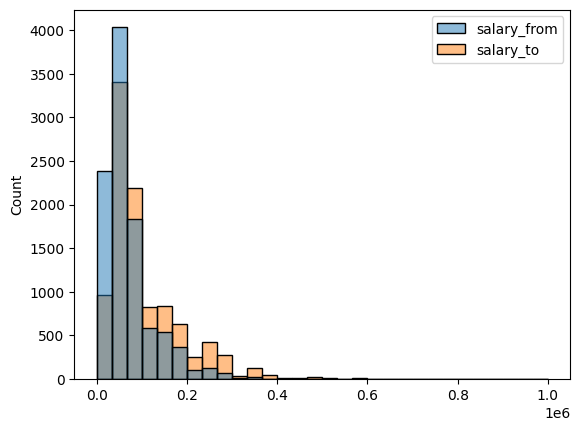

In [64]:
query_4_3 = f'''
SELECT salary_from as salary_from, salary_to as salary_to
FROM vacancies
'''
df = pd.read_sql_query(query_4_3, connection)
df.dropna(inplace=True)
sns.histplot(data=df, bins=30);

In [65]:
# Закрываемм дорогостоящий ресурс - соединение
connection.close()